# Inteligência Artificial Aplicada a Finanças

### Projeto 7 - Blockchain e IA Para Gestão de Empréstimos Pessoais – Clube do Empréstimo

![title](imagens/projeto7.png)

## Definindo um Sub-Problema

Usando dados históricos sobre empréstimos do Lendig Club - incluindo informações sobre se o tomador do empréstimo pagou ou não o empréstimo - o principal objetivo deste trabalho será prever se um potencial mutuário provavelmente pagará o empréstimo.

Após explorar e pré-processar os dados, vamos treinar um modelo de classificação binária de Rede Neural Artificial para atingir esse objetivo. Por fim, avaliamos o desempenho do modelo e simulamos seu funcionamento fazendo previsões com um novo tomador de empréstimo.

## Fonte de Dados

Leia o manual em pdf no Capítulo 10 do curso.

## Instalando e Carregando Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.5


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import warnings
warnings.simplefilter(action='ignore')

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.19.2
sklearn   : 0.23.2
matplotlib: 3.3.2
tensorflow: 2.4.1
pandas    : 1.1.3
seaborn   : 0.11.0



## Carregando os Dados

In [5]:
# Carrega os dados
df_aprovado = pd.read_csv("dados/accepted_2007_to_2018Q4.csv")

In [6]:
# Info
df_aprovado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [7]:
# Shape
df_aprovado.shape

(2260701, 151)

In [8]:
# Amostra
df_aprovado.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Análise Exploratória

Como vamos prever o loan_status, vamos dar uma olhada mais de perto nessa variável:

In [9]:
# Total de registros por classe da variável de saída
df_aprovado.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

Por uma questão de simplicidade, vamos considerar apenas os valores _Fully Paid_ e _Charged Off_ :

In [10]:
# Filtrando o dataframe
df_aprovado = df_aprovado[df_aprovado.loan_status.isin(['Fully Paid', 'Charged Off'])]

In [11]:
# Shape
df_aprovado.shape

(1345310, 151)

<AxesSubplot:xlabel='loan_status', ylabel='count'>

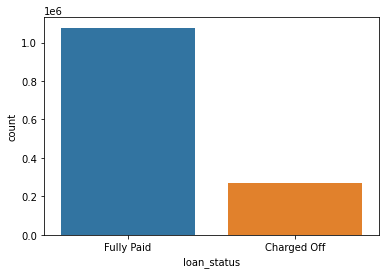

In [12]:
# Distribuição da classe
sns.countplot(x = "loan_status", data = df_aprovado)

Verificando agora valores nulos por coluna:

In [13]:
# Verificando valores nulos
df_aprovado.isnull().sum().sort_values(ascending = False)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
                                               ...   
pub_rec                                             0
open_acc                                            0
hardship_flag                                       0
fico_range_high                                     0
id                                                  0
Length: 151, dtype: int64

Há muitas colunas quase cheias de valores ausentes. Vamos verificar as primeiras 50 colunas classificadas por valores ausentes:

In [14]:
# Listando colunas com valores ausentes
df_aprovado.isnull().sum().sort_values(ascending = False).head(50)

member_id                                     1345310
next_pymnt_d                                  1345310
orig_projected_additional_accrued_interest    1341551
hardship_start_date                           1339556
hardship_end_date                             1339556
payment_plan_start_date                       1339556
hardship_length                               1339556
hardship_dpd                                  1339556
hardship_loan_status                          1339556
hardship_last_payment_amount                  1339556
hardship_payoff_balance_amount                1339556
hardship_amount                               1339556
hardship_status                               1339556
hardship_reason                               1339556
hardship_type                                 1339556
deferral_term                                 1339556
sec_app_mths_since_last_major_derog           1338665
sec_app_revol_util                            1327008
revol_bal_joint             

Vamos descartar essas colunas, pois não vai contribuir para o nosso objetivo.

In [15]:
# Drop das colunas com mais valores ausentes
cols_to_drop = df_aprovado.isnull().sum().sort_values(ascending = False).head(50).index
df_aprovado = df_aprovado.drop(columns = cols_to_drop)

In [16]:
# Shape
df_aprovado.shape

(1345310, 101)

Vamos checar novamente:

In [17]:
# Verificando valores ausentes
df_aprovado.isnull().sum().sort_values(ascending = False).head(50)

open_il_24m                   807712
inq_fi                        807712
open_rv_24m                   807712
open_rv_12m                   807712
open_act_il                   807712
max_bal_bc                    807712
total_bal_il                  807712
mths_since_last_delinq        678743
mths_since_recent_inq         174071
num_tl_120dpd_2m              117401
mo_sin_old_il_acct            105575
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67549
num_rev_accts                  67528
mo_sin_old_rev_tl_op           67528
mo_sin_rcnt_rev_tl_op          67528
mo_sin_rcnt_tl                 67527
num_accts_ever_120_pd          67527
num_actv_rev_tl                67527
num_actv_bc_tl                 67527
num_bc_tl                      67527
num_tl_op_past_12m             67527
num_tl_90g_dpd_24m             67527
total_il_high_credit_limit     67527
tot_coll_amt                   67527
t

Precisamos eliminar mais colunas:

In [18]:
# Eliminando colunas com valores ausentes
cols_to_drop = df_aprovado.isnull().sum().sort_values(ascending = False).head(45).index
df_aprovado = df_aprovado.drop(columns = cols_to_drop)

In [19]:
# Shape
df_aprovado.shape

(1345310, 56)

Para as colunas restantes com valores ausentes, vamos ver a porcentagem de valores ausentes:

In [20]:
# Percentual de valores ausentes
nulls = df_aprovado.isnull().sum().sort_values(ascending = False)
nulls_percentage = (nulls/df_aprovado.shape[0]*100)
nulls_percentage.head(15)

last_pymnt_d                  0.171931
revol_util                    0.063703
pub_rec_bankruptcies          0.051810
dti                           0.027800
collections_12_mths_ex_med    0.004163
chargeoff_within_12_mths      0.004163
last_credit_pull_d            0.004088
tax_liens                     0.002899
zip_code                      0.000074
inq_last_6mths                0.000074
issue_d                       0.000000
addr_state                    0.000000
delinq_2yrs                   0.000000
earliest_cr_line              0.000000
purpose                       0.000000
dtype: float64

As colunas restantes têm pontos de dados ausentes, mas representam menos de 0,2% do total de dados.
Vamos remover as linhas que não têm valores nessas colunas com dropna():

In [21]:
# Removendo registros com valores ausentes
df_aprovado = df_aprovado.dropna()

In [22]:
# Shape
df_aprovado.shape

(1341026, 56)

In [23]:
# Info
df_aprovado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 56 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   funded_amnt                 1341026 non-null  float64
 3   funded_amnt_inv             1341026 non-null  float64
 4   term                        1341026 non-null  object 
 5   int_rate                    1341026 non-null  float64
 6   installment                 1341026 non-null  float64
 7   grade                       1341026 non-null  object 
 8   sub_grade                   1341026 non-null  object 
 9   home_ownership              1341026 non-null  object 
 10  annual_inc                  1341026 non-null  float64
 11  verification_status         1341026 non-null  object 
 12  issue_d                     1341026 non-null  object 
 1

Vamos agora dar uma olhada no histograma loan_amnt, para ter uma ideia da distribuição do valor:

<AxesSubplot:xlabel='loan_amnt', ylabel='Count'>

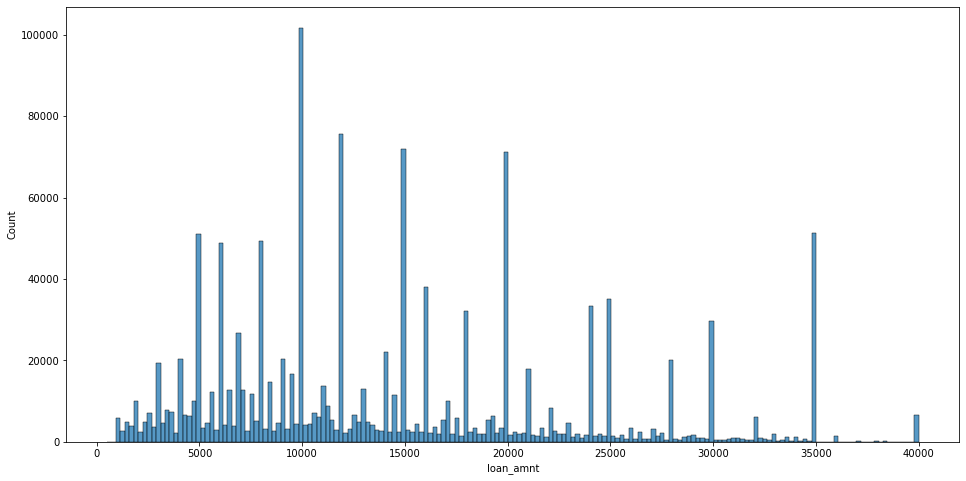

In [24]:
# Histograma
plt.figure(figsize = (16,8))
sns.histplot(df_aprovado.loan_amnt, kde = False)

Vamos agora ver a correlação entre variáveis contínuas:

<AxesSubplot:>

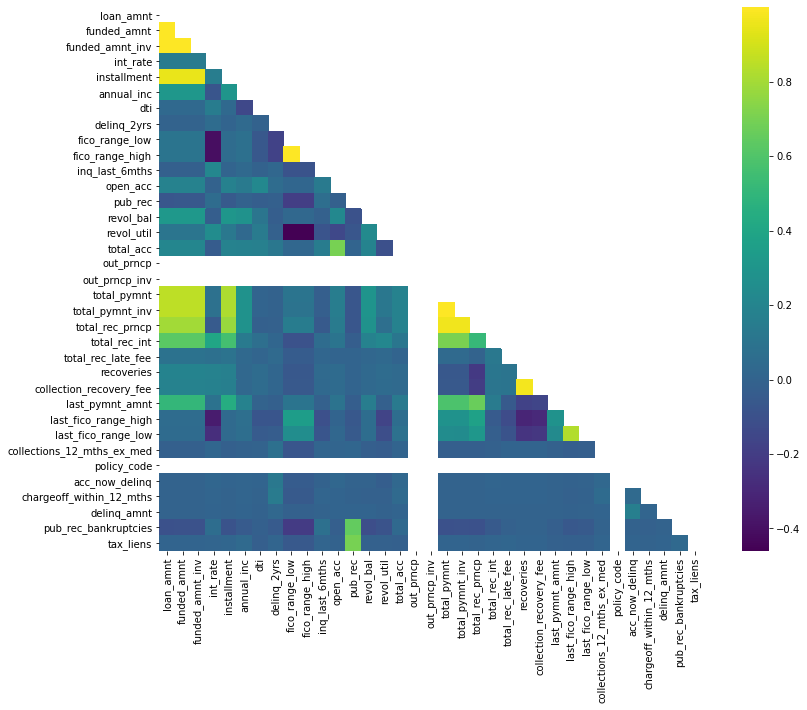

In [25]:
# Correlação
plt.figure(figsize = (14,10))
mask = np.zeros_like(df_aprovado.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_aprovado.corr(), cmap = 'viridis', mask = mask, annot = False, square = True)

Existem 3 colunas com um comportamento diferente visível:
out_prncp, out_prncp_inv and policy_code.

In [26]:
print(df_aprovado.out_prncp.value_counts())
print(df_aprovado.out_prncp_inv.value_counts())
print(df_aprovado.policy_code.value_counts())

0.0    1341026
Name: out_prncp, dtype: int64
0.0    1341026
Name: out_prncp_inv, dtype: int64
1.0    1341026
Name: policy_code, dtype: int64


Estas são colunas com valores constantes. Nós podemos removê-las também.

In [27]:
# Drop das colunas
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_aprovado = df_aprovado.drop(columns = cols_to_drop)

In [28]:
# Shappe
df_aprovado.shape

(1341026, 53)

<AxesSubplot:>

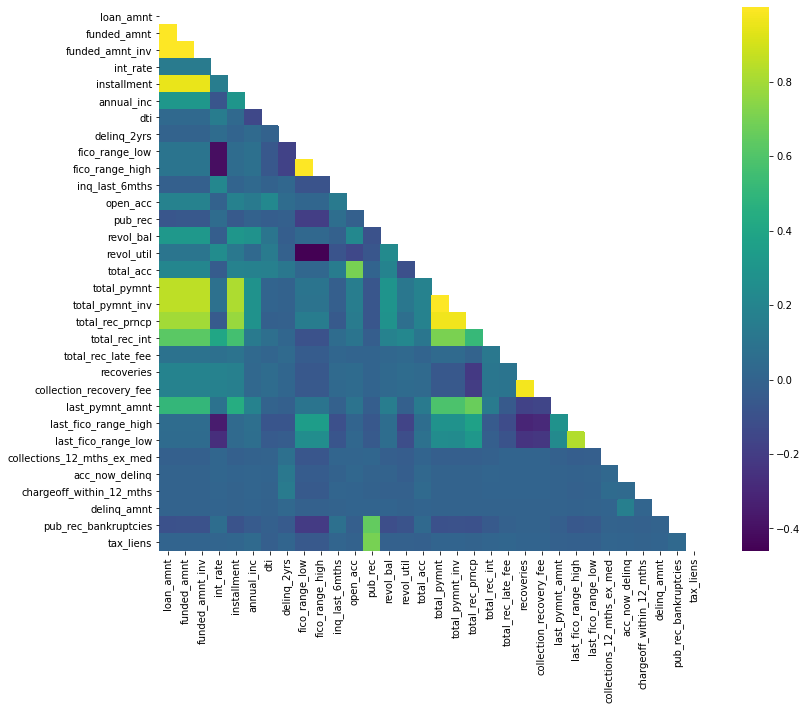

In [29]:
# Correlação
plt.figure(figsize = (14,10))
mask = np.zeros_like(df_aprovado.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_aprovado.corr(), cmap = 'viridis', mask = mask, annot = False, square = True)

Existem muitos quadrados amarelados. Isso indica uma correlação quase perfeita entre muitas variáveis. Vamos aprofundar:

In [30]:
# Vamos detalhar a correlação para verificar os pares de correlação mais altos

# Pares
c = df_aprovado.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending = False)

# Correlação
corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['atributo1', 'atributo2', 'corr']

# Verifica os pares de recursos acima de 0,8 na correlação
cond1 = (corr_pairs.atributo1 != corr_pairs.atributo2)
cond2 = (corr_pairs['corr'] > 0.80)
corr_pairs[cond1 & cond2]

,atributo1,atributo2,corr
1,fico_range_high,fico_range_low,1.000000
2,loan_amnt,funded_amnt,0.999565
3,total_pymnt,total_pymnt_inv,0.999541
4,funded_amnt_inv,funded_amnt,0.999439
5,loan_amnt,funded_amnt_inv,0.998918
6,collection_recovery_fee,recoveries,0.972674
7,total_rec_prncp,total_pymnt,0.967104
8,total_rec_prncp,total_pymnt_inv,0.966725
9,funded_amnt,installment,0.954037
10,funded_amnt_inv,installment,0.953445


Vamos criar um gráfico de dispersão e verificar visualmente algumas relações entre esses atributos:

<AxesSubplot:xlabel='fico_range_low', ylabel='fico_range_high'>

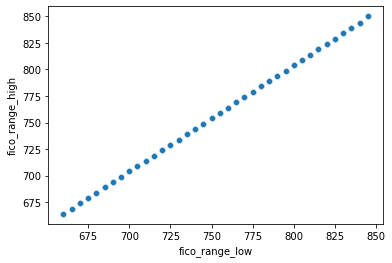

In [31]:
sns.scatterplot(x = df_aprovado.fico_range_low, y = df_aprovado.fico_range_high)

<AxesSubplot:xlabel='funded_amnt', ylabel='loan_amnt'>

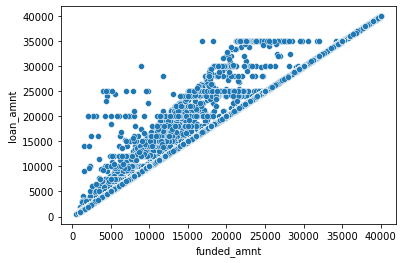

In [32]:
sns.scatterplot(x = df_aprovado.funded_amnt, y = df_aprovado.loan_amnt)

<AxesSubplot:xlabel='funded_amnt', ylabel='funded_amnt_inv'>

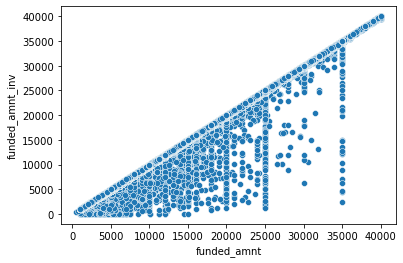

In [33]:
sns.scatterplot(x = df_aprovado.funded_amnt, y = df_aprovado.funded_amnt_inv)

<AxesSubplot:xlabel='total_pymnt', ylabel='installment'>

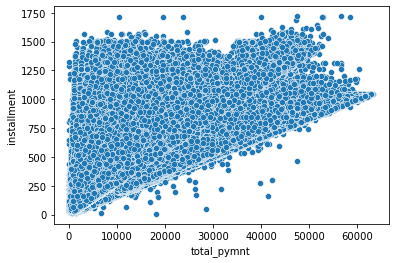

In [34]:
sns.scatterplot(x = df_aprovado.total_pymnt, y = df_aprovado.installment)

Parece que temos muitas informações "duplicadas". Vamos eliminar algumas colunas, com base na inspeção visual no dataframe corr_pairs:

In [35]:
# Drop de colunas
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_aprovado = df_aprovado.drop(columns = cols_to_drop)

In [36]:
# Shape
df_aprovado.shape

(1341026, 44)

Como nossa coluna de destino é categórica (loan_status), vamos criar um novo recurso - loan_paid - que é 1 para 'Fully Paid' e 0 para 'Charged Off'.

In [37]:
# Encoding
values = df_aprovado.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))

In [38]:
# Nova coluna
df_aprovado['loan_paid'] = df_aprovado['loan_status'].map(d)
df_aprovado = df_aprovado.drop(columns=['loan_status'])

<AxesSubplot:>

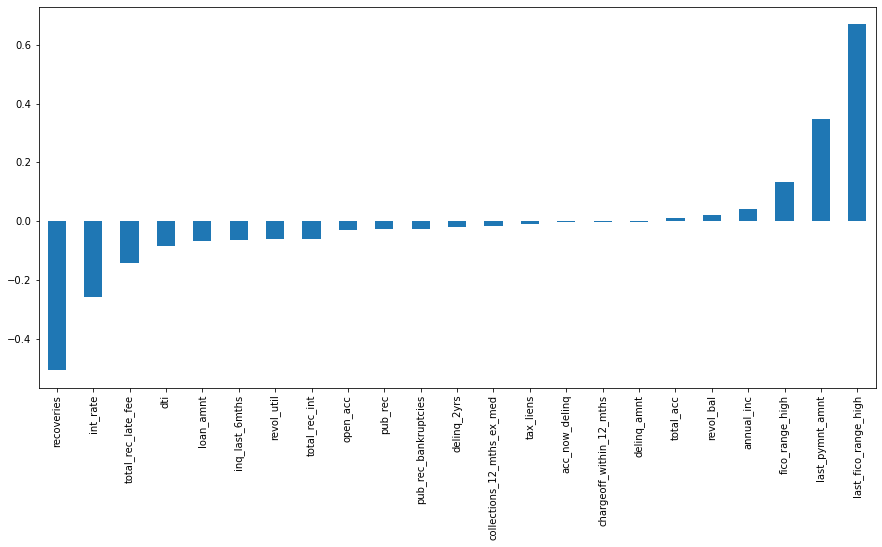

In [39]:
# Verificando a correlação de recursos com a nova coluna loan_paid
plt.figure(figsize = (15,7))
new_corr = df_aprovado.corr().iloc[:-1,-1].sort_values()
new_corr.plot.bar(rot=90)

## Pré-Processamento

### Tratamento de Variáveis Categóricas Constantes

Ainda temos muitas colunas categóricas de string. Vamos trabalhar nisso:

In [40]:
# Info
df_aprovado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 44 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   id                          1341026 non-null  object 
 1   loan_amnt                   1341026 non-null  float64
 2   term                        1341026 non-null  object 
 3   int_rate                    1341026 non-null  float64
 4   grade                       1341026 non-null  object 
 5   sub_grade                   1341026 non-null  object 
 6   home_ownership              1341026 non-null  object 
 7   annual_inc                  1341026 non-null  float64
 8   verification_status         1341026 non-null  object 
 9   issue_d                     1341026 non-null  object 
 10  pymnt_plan                  1341026 non-null  object 
 11  url                         1341026 non-null  object 
 12  purpose                     1341026 non-null  object 
 1

In [41]:
# Visualiza os dados
df_aprovado.head()

,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1


In [42]:
# Listamos as variáveis categóricas (do tipo object)
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['id', 'term', 'grade', 'sub_grade', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'hardship_flag', 'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


In [43]:
# Filtramos o  dataframe pelas variáveis categóricas
df_aprovado[cat_cols]

,id,term,grade,sub_grade,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,36 months,C,C4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,68355089,36 months,C,C1,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,68341763,60 months,B,B4,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
4,68476807,60 months,F,F1,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N
5,68426831,36 months,C,C3,RENT,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,GA,Oct-1987,w,May-2017,May-2017,Individual,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,60 months,B,B2,OWN,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,775xx,TX,Jul-2004,f,Aug-2018,Mar-2019,Individual,N,Cash,N
2260690,88948836,60 months,C,C3,MORTGAGE,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,900xx,CA,Mar-2002,f,Jul-2018,Jul-2018,Individual,N,Cash,N
2260691,89996426,60 months,C,C4,MORTGAGE,Source Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,863xx,AZ,Jun-2011,f,Mar-2017,Dec-2018,Individual,N,Cash,N
2260692,90006534,60 months,C,C1,RENT,Not Verified,Oct-2016,n,https://lendingclub.com/browse/loanDetail.acti...,medical,284xx,NC,Aug-1997,f,Mar-2018,Mar-2019,Individual,N,Cash,N


Algumas colunas de variáveis categóricas apresentam valores constantes (a exemplo do que tínhamos com colunas do tipo numérico). Vamos remover.

In [44]:
print(df_aprovado.pymnt_plan.value_counts())
print(df_aprovado.hardship_flag.value_counts())

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64


In [45]:
# Drop de colunas constantes
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_aprovado = df_aprovado.drop(columns = cols_to_drop)

In [46]:
# Shape
df_aprovado.shape

(1341026, 41)

In [47]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### Engenharia de Atributos - Variável "term"

In [48]:
print(df_aprovado.term.value_counts())

 36 months    1017398
 60 months     323628
Name: term, dtype: int64


In [49]:
# Converte a variável term em um tipo de dados numéricos de valor 36 ou 60 
l1 = df_aprovado.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))
df_aprovado['term'] = df_aprovado['term'].map(d)

In [50]:
df_aprovado['term']

0          36
1          36
2          60
4          60
5          36
           ..
2260688    60
2260690    60
2260691    60
2260692    60
2260697    60
Name: term, Length: 1341026, dtype: int64

In [51]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### Engenharia de Atributos - Variável "grade" e "sub_grade"

In [52]:
print(df_aprovado.grade.value_counts())
print(df_aprovado.sub_grade.value_counts())

B    391850
C    380490
A    234657
D    200019
E     93126
F     31854
G      9030
Name: grade, dtype: int64
C1    85247
B4    83003
B5    82327
B3    81658
C2    78960
C3    74781
C4    74173
B2    73870
B1    70992
C5    67329
A5    63892
A4    52135
D1    51092
D2    44637
A1    43634
D3    39134
A3    37900
A2    37096
D4    35412
D5    29744
E1    23657
E2    21244
E3    18279
E4    15621
E5    14325
F1     9914
F2     7149
F3     6055
F4     4826
F5     3910
G1     2967
G2     2109
G3     1600
G4     1259
G5     1095
Name: sub_grade, dtype: int64


<AxesSubplot:xlabel='grade', ylabel='count'>

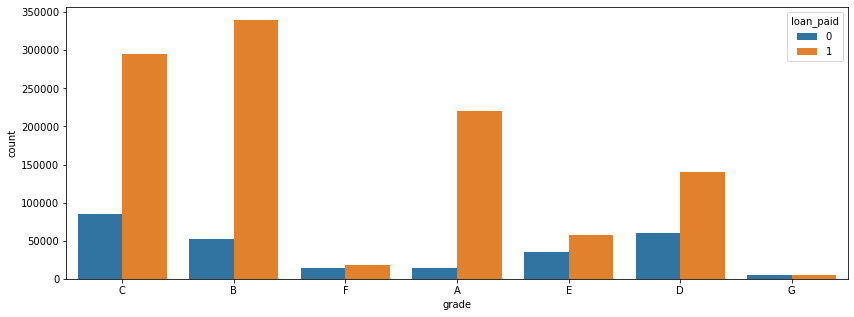

In [53]:
# Plot para contagem da variável target pela variável grade
plt.figure(figsize = (14,5))
sns.countplot(x = df_aprovado.grade, hue = df_aprovado.loan_paid)

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

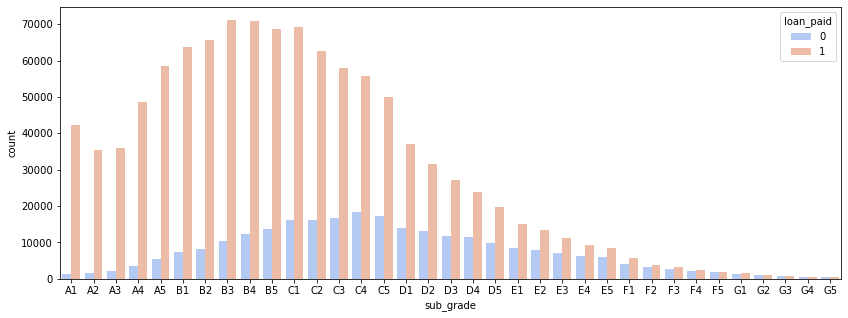

In [54]:
# Plot para contagem da variável target pela variável sub_grade
l = list(df_aprovado.sub_grade.unique())
l.sort()
plt.figure(figsize = (14,5))
sns.countplot(x = df_aprovado.sub_grade, order = l, hue = df_aprovado.loan_paid, palette = 'coolwarm')

In [55]:
# Visto que a variável grade é parte de sub_grade, então vamos deixar de lado o recurso de grade.
df_aprovado = df_aprovado.drop(columns = 'grade')

E então criamos variáveis dummy para cada catagoria.

In [56]:
# Cria variáveis dummy
df_aprovado = pd.get_dummies(df_aprovado, columns = ['sub_grade'], prefix = '', prefix_sep = '', drop_first = True)

In [57]:
# Visualiza os dados
df_aprovado.head()

,loan_amnt,term,int_rate,home_ownership,annual_inc,verification_status,issue_d,url,purpose,zip_code,...,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5
0,3600.0,36,13.99,MORTGAGE,55000.0,Not Verified,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,190xx,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,36,11.99,MORTGAGE,65000.0,Not Verified,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,small_business,577xx,...,0,0,0,0,0,0,0,0,0,0
2,20000.0,60,10.78,MORTGAGE,63000.0,Not Verified,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,605xx,...,0,0,0,0,0,0,0,0,0,0
4,10400.0,60,22.45,MORTGAGE,104433.0,Source Verified,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,174xx,...,1,0,0,0,0,0,0,0,0,0
5,11950.0,36,13.44,RENT,34000.0,Source Verified,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,300xx,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


### Engenharia de Atributos - Variáveis "verification_status", "application_type", "initial_list_status", "purpose"

In [59]:
print(df_aprovado.verification_status.unique())
print(df_aprovado.application_type.unique())
print(df_aprovado.initial_list_status.unique())
print(df_aprovado.purpose.unique())

['Not Verified' 'Source Verified' 'Verified']
['Individual' 'Joint App']
['w' 'f']
['debt_consolidation' 'small_business' 'home_improvement' 'major_purchase'
 'credit_card' 'other' 'house' 'vacation' 'car' 'medical' 'moving'
 'renewable_energy' 'wedding' 'educational']


Para essas colunas, vamos apenas criar variáveis fictícias (dummy), concatená-las com o dataframe original e eliminar o original.

In [60]:
# Cria variáveis dummy
df_aprovado = pd.get_dummies(df_aprovado, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_aprovado = pd.get_dummies(df_aprovado, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_aprovado = pd.get_dummies(df_aprovado, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_aprovado = pd.get_dummies(df_aprovado, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)

In [61]:
# Visualiza os dados
df_aprovado.head()

,loan_amnt,term,int_rate,home_ownership,annual_inc,issue_d,url,zip_code,addr_state,dti,...,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,3600.0,36,13.99,MORTGAGE,55000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,190xx,PA,5.91,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,36,11.99,MORTGAGE,65000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,577xx,SD,16.06,...,0,0,0,0,0,0,0,1,0,0
2,20000.0,60,10.78,MORTGAGE,63000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,605xx,IL,10.78,...,1,0,0,0,0,0,0,0,0,0
4,10400.0,60,22.45,MORTGAGE,104433.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,174xx,PA,25.37,...,0,0,1,0,0,0,0,0,0,0
5,11950.0,36,13.44,RENT,34000.0,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,300xx,GA,10.20,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['home_ownership', 'issue_d', 'url', 'zip_code', 'addr_state',
       'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')


### Engenharia de Atributos - Variável "home_ownership"

In [63]:
# Contagem por categoria
df_aprovado.home_ownership.value_counts()

MORTGAGE    663868
RENT        532493
OWN         144195
ANY            283
OTHER          142
NONE            45
Name: home_ownership, dtype: int64

In [64]:
# Substitui None por Any
df_aprovado['home_ownership'] = df_aprovado.home_ownership.replace('NONE', 'ANY')

In [65]:
# Cria variáveis dummy
df_aprovado = pd.get_dummies(df_aprovado, columns = ['home_ownership'], 
                             prefix = '', 
                             prefix_sep = '', 
                             drop_first = True)

In [66]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['issue_d', 'url', 'zip_code', 'addr_state', 'earliest_cr_line',
       'last_pymnt_d', 'last_credit_pull_d', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')


### Engenharia de Atributos - Variáveis "issue_d", "url, last_pymnt_d" e "last_credit_pull_d"

In [67]:
df_aprovado.issue_d.head(10)

0     Dec-2015
1     Dec-2015
2     Dec-2015
4     Dec-2015
5     Dec-2015
6     Dec-2015
7     Dec-2015
8     Dec-2015
9     Dec-2015
12    Dec-2015
Name: issue_d, dtype: object

In [68]:
# Vamos apenas dropar as variáveis, pois o valor parece ser constante
df_aprovado = df_aprovado.drop(columns = ['issue_d', 'url', 'last_pymnt_d', 'last_credit_pull_d'])

### Engenharia de Atributos - Variáveis "zip_code" e "addr_state"

In [69]:
df_aprovado.zip_code.value_counts()

945xx    14964
750xx    14440
112xx    13781
606xx    12407
300xx    12087
         ...  
698xx        1
568xx        1
009xx        1
892xx        1
095xx        1
Name: zip_code, Length: 943, dtype: int64

In [70]:
# Não parece ser informação relevante, vamos dropar as colunas
df_aprovado = df_aprovado.drop(columns = ['zip_code', 'addr_state'])

In [71]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include=['object']).columns
print(cat_cols)

Index(['earliest_cr_line', 'disbursement_method', 'debt_settlement_flag'], dtype='object')


### Engenharia de Atributos - Variáveis "disbursement_method" e "debt_settlement_flag"

In [72]:
print(df_aprovado.disbursement_method.value_counts())
print(df_aprovado.debt_settlement_flag.value_counts())

Cash         1334162
DirectPay       6864
Name: disbursement_method, dtype: int64
N    1307844
Y      33182
Name: debt_settlement_flag, dtype: int64


Criaremos variáveis dummy.

In [73]:
# Cria variáveis dummy
df_aprovado = pd.get_dummies(df_aprovado, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_aprovado = pd.get_dummies(df_aprovado, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)

### Engenharia de Atributos - Variáveis "earliest_cr_line"

In [74]:
print(df_aprovado.earliest_cr_line.value_counts())

Aug-2001    9365
Aug-2002    9066
Sep-2003    9000
Oct-2001    8838
Aug-2000    8822
            ... 
Jun-1949       1
May-1950       1
Oct-1954       1
Sep-1953       1
Feb-1957       1
Name: earliest_cr_line, Length: 739, dtype: int64


In [75]:
# Drop da coluna pois não parece ser relevante
df_aprovado = df_aprovado.drop(columns = ['earliest_cr_line'])

In [76]:
# Variáveis categóricas restantes
cat_cols = df_aprovado.select_dtypes(include=['object']).columns
print(cat_cols)

Index([], dtype='object')


In [77]:
# Info
df_aprovado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341026 entries, 0 to 2260697
Data columns (total 82 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   loan_amnt                   1341026 non-null  float64
 1   term                        1341026 non-null  int64  
 2   int_rate                    1341026 non-null  float64
 3   annual_inc                  1341026 non-null  float64
 4   dti                         1341026 non-null  float64
 5   delinq_2yrs                 1341026 non-null  float64
 6   fico_range_high             1341026 non-null  float64
 7   inq_last_6mths              1341026 non-null  float64
 8   open_acc                    1341026 non-null  float64
 9   pub_rec                     1341026 non-null  float64
 10  revol_bal                   1341026 non-null  float64
 11  revol_util                  1341026 non-null  float64
 12  total_acc                   1341026 non-null  float64
 1

## Modelagem Preditiva

Agora trabalhamos na modelagem preditiva!

In [78]:
# Começamos separando as variáveis X (entrada) e y (saída)
df = df_aprovado.copy()
X = df.loc[:, df.columns != 'loan_paid'].values
y = df.loan_paid.values

In [79]:
# Divisão em dados de treino e teste com proporção 80/20
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.2, random_state = 42)

Precisamos padronizar os dados e colocá-los na mesma escala.

In [80]:
# Visualiza os dados
df_aprovado.head()

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,...,renewable_energy,small_business,vacation,wedding,MORTGAGE,OTHER,OWN,RENT,DirectPay,Y
0,3600.0,36,13.99,55000.0,5.91,0.0,679.0,1.0,7.0,0.0,...,0,0,0,0,1,0,0,0,0,0
1,24700.0,36,11.99,65000.0,16.06,1.0,719.0,4.0,22.0,0.0,...,0,1,0,0,1,0,0,0,0,0
2,20000.0,60,10.78,63000.0,10.78,0.0,699.0,0.0,6.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,10400.0,60,22.45,104433.0,25.37,1.0,699.0,3.0,12.0,0.0,...,0,0,0,0,1,0,0,0,0,0
5,11950.0,36,13.44,34000.0,10.20,0.0,694.0,0.0,5.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [81]:
# Cria o scaler
scaler = MinMaxScaler()

In [82]:
# Fit e transform em treino
X_treino = scaler.fit_transform(X_treino)

# Somente transform em teste
X_teste = scaler.transform(X_teste)

In [83]:
print(X_treino.shape)
print(X_teste.shape)

(1072820, 81)
(268206, 81)


### Construção do Modelo

www.deeplearningbook.com.br

In [84]:
# Modelo
modelo = Sequential()
modelo.add(Dense(units = 78, activation = 'relu'))
modelo.add(Dense(units = 39, activation = 'relu'))
modelo.add(Dense(units = 19, activation = 'relu'))
modelo.add(Dense(units = 8, activation = 'relu'))
modelo.add(Dense(units = 4, activation = 'relu'))
modelo.add(Dense(units = 1, activation = 'sigmoid'))

In [85]:
# Compilação do modelo
modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [86]:
# Treinamento do modelo
modelo.fit(x = X_treino, 
           y = y_treino, 
           epochs = 40,
           batch_size = 512,
           validation_data = (X_teste, y_teste), 
           verbose = 1)

Epoch 1/40
2096/2096 [==============================] - 6s 2ms/step - loss: 0.1970 - accuracy: 0.9153 - val_loss: 0.0821 - val_accuracy: 0.9677
Epoch 2/40
2096/2096 [==============================] - 4s 2ms/step - loss: 0.0811 - accuracy: 0.9683 - val_loss: 0.0827 - val_accuracy: 0.9672
Epoch 3/40
2096/2096 [==============================] - 3s 2ms/step - loss: 0.0721 - accuracy: 0.9720 - val_loss: 0.0743 - val_accuracy: 0.9712
Epoch 4/40
2096/2096 [==============================] - 4s 2ms/step - loss: 0.0675 - accuracy: 0.9743 - val_loss: 0.0625 - val_accuracy: 0.9764
Epoch 5/40
2096/2096 [==============================] - 4s 2ms/step - loss: 0.0635 - accuracy: 0.9759 - val_loss: 0.0651 - val_accuracy: 0.9754
Epoch 6/40
2096/2096 [==============================] - 3s 2ms/step - loss: 0.0607 - accuracy: 0.9772 - val_loss: 0.0586 - val_accuracy: 0.9782
Epoch 7/40
2096/2096 [==============================] - 4s 2ms/step - loss: 0.0576 - accuracy: 0.9788 - val_loss: 0.0554 - val_accuracy:

In [87]:
# Sumário
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 78)                6396      
_________________________________________________________________
dense_1 (Dense)              (None, 39)                3081      
_________________________________________________________________
dense_2 (Dense)              (None, 19)                760       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 160       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 10,438
Trainable params: 10,438
Non-trainable params: 0
____________________________________________________

### Avaliação do Modelo

In [88]:
# Erros do modelo
losses = pd.DataFrame(modelo.history.history)

<AxesSubplot:>

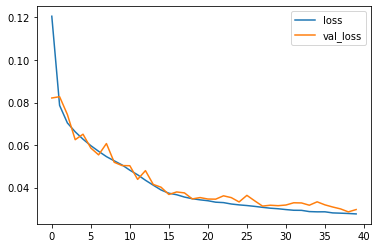

In [89]:
# Plot do erro
losses[['loss','val_loss']].plot()

<AxesSubplot:>

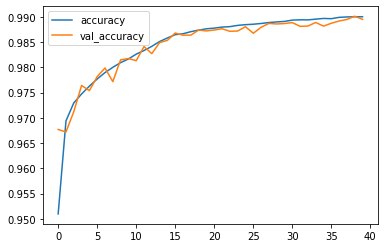

In [90]:
# Plot da acurácia
losses[['accuracy','val_accuracy']].plot()

In [91]:
# Previsões
previsoes = (modelo.predict(X_teste) > 0.5).astype("int32")

In [92]:
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     53089
           1       0.99      0.99      0.99    215117

    accuracy                           0.99    268206
   macro avg       0.98      0.98      0.98    268206
weighted avg       0.99      0.99      0.99    268206



In [93]:
# Matriz de confusão
pd.DataFrame(confusion_matrix(y_teste, previsoes))

,0,1
0,51622,1467
1,1344,213773


## Previsões com um Novo Usuário

In [94]:
import random

df_aprovado = df_aprovado.reset_index(drop=True)

random.seed(101)
random_ind = random.randint(0,len(df_aprovado))

novo_usuario = df_aprovado.drop('loan_paid', axis = 1).iloc[random_ind]
novo_usuario

loan_amnt      29675.00
term              36.00
int_rate          10.99
annual_inc    125565.00
dti                7.67
                ...    
OTHER              0.00
OWN                0.00
RENT               0.00
DirectPay          0.00
Y                  0.00
Name: 1218764, Length: 81, dtype: float64

In [95]:
# Padroniza os dados do novo usuário
novo_c = scaler.transform(novo_usuario.values.reshape(1,81))

In [96]:
print(f"Clube do Empréstimo - Previsão de Pagamento Para Novo Usuário (1 - vai pagar / 0 - não vai pagar)")
print(f"Previsão do Modelo Para Este Usuário: {(modelo.predict(novo_c) > 0.5).astype('int32')[0][0]}")

Clube do Empréstimo - Previsão de Pagamento Para Novo Usuário (1 - vai pagar / 0 - não vai pagar)
Previsão do Modelo Para Este Usuário: 1


In [97]:
# Vamos verificar o status histórico desse usuário
df_aprovado.loc[random_ind, 'loan_paid']

1

# Fim